In [0]:
import urllib.request 
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
import matplotlib.pyplot as plt
from pyspark.sql.functions import when
from pyspark.ml.classification import LinearSVC, GBTClassifier, MultilayerPerceptronClassifier
from pyspark.ml.feature import (StringIndexer, OneHotEncoder, VectorAssembler)
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#### Part A2

In [0]:
display(dbutils.fs.ls("dbfs:/FileStore/tables/kddcup_data_10_percent.gz"))

path,name,size,modificationTime
dbfs:/FileStore/tables/kddcup_data_10_percent.gz,kddcup_data_10_percent.gz,2144903,1677090361000


#### Part A3

In [0]:
# start spark session
spark = SparkSession.builder.getOrCreate()

# filename and path
filepath = 'dbfs:/FileStore/tables/kddcup_data_10_percent.gz'

# read text file
rdd   = spark.sparkContext.textFile(filepath)

# print top 10 values
print(f'The first 10 values of the data are: {rdd.take(10)}')
print(f'The type of data structure is {type(rdd)}')

The first 10 values of the data are: ['0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.', '0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,19,19,1.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,normal.', '0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,29,29,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.', '0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,39,39,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.', '0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,49,49,1.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,normal.', '0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,59,59,1.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,normal.', '0,tcp,http,SF,212,1940,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2

#### Part A4

In [0]:
rdd_processed   = rdd.flatMap(lambda x: x.split())
print(f'An example entry in the RDD is {rdd_processed.take(1)}')

example_row = rdd_processed.take(1)
example_row = example_row[0].split(",")
print(f'The total number of features are {len(example_row)}')
print(f'The total number of entries are {len(rdd_processed.collect())}')

An example entry in the RDD is ['0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.']
The total number of features are 42
The total number of entries are 494021


#### Part A5

In [0]:
rdd_six_columns = rdd_processed.map(lambda p: Row(
                                    duration      = int(p.split(",")[0]), 
                                    protocol_type = str(p.split(",")[1]),
                                    service       = str(p.split(",")[2]),
                                    flag          = str(p.split(",")[3]),
                                    src_bytes     = int(p.split(",")[4]),
                                    dst_bytes     = int(p.split(",")[5]),
                                    label         = str(p.split(",")[-1])
                                    ))

df = rdd_six_columns.toDF()
df.printSchema()
df.show(10)

root
 |-- duration: long (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: long (nullable = true)
 |-- dst_bytes: long (nullable = true)
 |-- label: string (nullable = true)

+--------+-------------+-------+----+---------+---------+-------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|  label|
+--------+-------------+-------+----+---------+---------+-------+
|       0|          tcp|   http|  SF|      181|     5450|normal.|
|       0|          tcp|   http|  SF|      239|      486|normal.|
|       0|          tcp|   http|  SF|      235|     1337|normal.|
|       0|          tcp|   http|  SF|      219|     1337|normal.|
|       0|          tcp|   http|  SF|      217|     2032|normal.|
|       0|          tcp|   http|  SF|      217|     2032|normal.|
|       0|          tcp|   http|  SF|      212|     1940|normal.|
|       0|          tcp|   http|  SF|      159|     4087|norm

#### Part A6

The total number of connections based on protocol_type are {'udp': 20354, 'tcp': 190065, 'icmp': 283602}


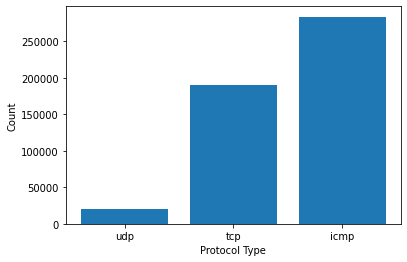

In [0]:
# analysis based on protocol type
data_protocol_type = df.rdd.map(lambda x: x.protocol_type).collect()

dictionary = {}
for item in data_protocol_type:
    if item not in dictionary.keys():
        dictionary[item] = 1
    else:
        dictionary[item] += 1
        
dictionary = dict(sorted(dictionary.items(), key=lambda item: item[1]))
print(f'The total number of connections based on protocol_type are {dictionary}')

# plot
names  = list(dictionary.keys())
values = list(dictionary.values())

plt.bar(range(len(dictionary)), values, tick_label=names)
plt.xlabel('Protocol Type')
plt.ylabel('Count')
plt.show()

The total number of connections based on service are {'pm_dump': 1, 'tftp_u': 1, 'red_i': 1, 'tim_i': 7, 'X11': 11, 'urh_i': 14, 'IRC': 43, 'Z39_50': 92, 'netstat': 95, 'ctf': 97, 'name': 98, 'kshell': 98, 'http_443': 99, 'exec': 99, 'netbios_dgm': 99, 'pop_2': 101, 'ldap': 101, 'link': 102, 'netbios_ns': 102, 'daytime': 103, 'efs': 103, 'login': 104, 'hostnames': 104, 'ssh': 105, 'nnsp': 105, 'supdup': 105, 'uucp': 106, 'klogin': 106, 'uucp_path': 106, 'vmnet': 106, 'bgp': 106, 'mtp': 107, 'sunrpc': 107, 'netbios_ssn': 107, 'nntp': 108, 'courier': 108, 'printer': 109, 'whois': 110, 'sql_net': 110, 'rje': 111, 'shell': 112, 'echo': 112, 'systat': 115, 'iso_tsap': 115, 'domain': 116, 'discard': 116, 'gopher': 117, 'imap4': 117, 'remote_job': 120, 'csnet_ns': 126, 'time': 157, 'pop_3': 202, 'auth': 328, 'ntp_u': 380, 'telnet': 513, 'urp_i': 538, 'finger': 670, 'ftp': 798, 'eco_i': 1642, 'ftp_data': 4721, 'domain_u': 5863, 'other': 7237, 'smtp': 9723, 'http': 64293, 'private': 110893, 'ec

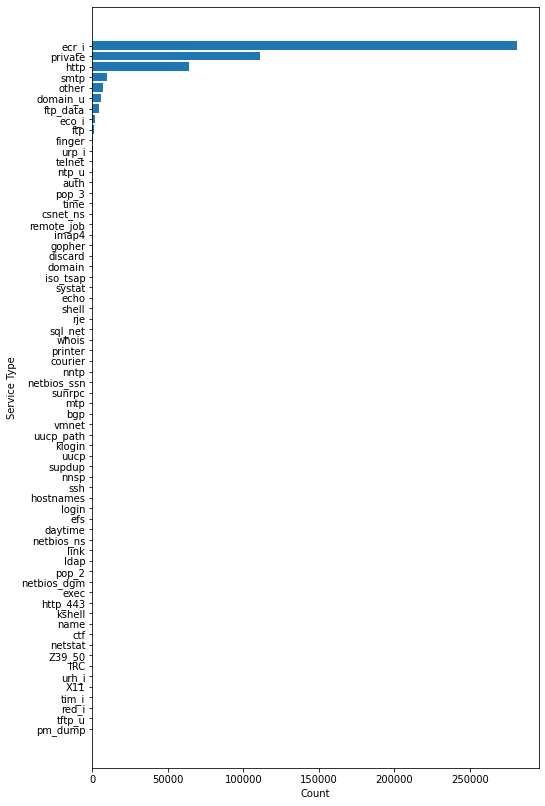

In [0]:
# analysis based on service type
data_service_type = df.rdd.map(lambda x: x.service).collect()

dictionary = {}
for item in data_service_type:
    if item not in dictionary.keys():
        dictionary[item] = 1
    else:
        dictionary[item] += 1
        
dictionary = dict(sorted(dictionary.items(), key=lambda item: item[1]))
print(f'The total number of connections based on service are {dictionary}')

# plot
names  = list(dictionary.keys())
values = list(dictionary.values())

plt.figure(figsize=(8,14))
plt.barh(names, values)
plt.xlabel('Count')
plt.ylabel('Service Type')
plt.show()

#### Part A7

The total number of connections based on label type are {'spy.': 2, 'perl.': 3, 'phf.': 4, 'multihop.': 7, 'ftp_write.': 8, 'loadmodule.': 9, 'rootkit.': 10, 'imap.': 12, 'warezmaster.': 20, 'land.': 21, 'buffer_overflow.': 30, 'guess_passwd.': 53, 'nmap.': 231, 'pod.': 264, 'teardrop.': 979, 'warezclient.': 1020, 'portsweep.': 1040, 'ipsweep.': 1247, 'satan.': 1589, 'back.': 2203, 'normal.': 97278, 'neptune.': 107201, 'smurf.': 280790}


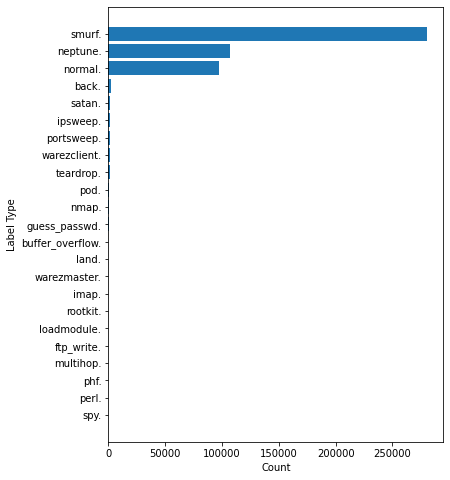

In [0]:
# analysis based on label
data_label_type = df.rdd.map(lambda x: x.label).collect()

dictionary = {}
for item in data_label_type:
    if item not in dictionary.keys():
        dictionary[item] = 1
    else:
        dictionary[item] += 1
        
dictionary = dict(sorted(dictionary.items(), key=lambda item: item[1]))
print(f'The total number of connections based on label type are {dictionary}')

# plot
names  = list(dictionary.keys())
values = list(dictionary.values())

plt.figure(figsize=(6,8))
plt.barh(names, values)
plt.xlabel('Count')
plt.ylabel('Label Type')
plt.show()

The total number of connections based on flag type are {'OTH': 8, 'S3': 10, 'RSTOS0': 11, 'S2': 24, 'S1': 57, 'SH': 107, 'RSTO': 579, 'RSTR': 903, 'REJ': 26875, 'S0': 87007, 'SF': 378440}


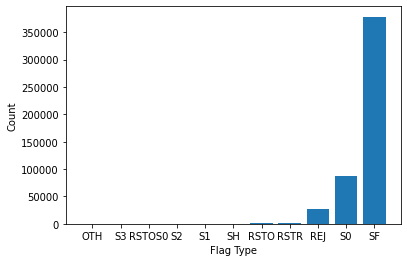

In [0]:
# analysis based on flag
data_flag_type = df.rdd.map(lambda x: x.flag).collect()

dictionary = {}
for item in data_flag_type:
    if item not in dictionary.keys():
        dictionary[item] = 1
    else:
        dictionary[item] += 1
        
dictionary = dict(sorted(dictionary.items(), key=lambda item: item[1]))
print(f'The total number of connections based on flag type are {dictionary}')

# plot
names  = list(dictionary.keys())
values = list(dictionary.values())

plt.bar(range(len(dictionary)), values, tick_label=names)
plt.ylabel('Count')
plt.xlabel('Flag Type')
plt.show()

The average number of bytes transferred from source to destination are 3025.61
The average number of bytes transferred from destination to source are 868.53


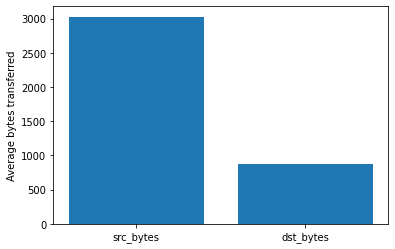

In [0]:
# analysis based on bytes transfer
data_src_bytes = df.rdd.map(lambda x: x.src_bytes).collect()
data_dst_bytes = df.rdd.map(lambda x: x.dst_bytes).collect()

avg_src_bytes = round(sum(data_src_bytes)/len(data_src_bytes), 2)
avg_dst_bytes = round(sum(data_dst_bytes)/len(data_dst_bytes), 2)

print(f'The average number of bytes transferred from source to destination are {avg_src_bytes}')
print(f'The average number of bytes transferred from destination to source are {avg_dst_bytes}')

# plot
plt.bar(range(2), [avg_src_bytes, avg_dst_bytes], tick_label=['src_bytes', 'dst_bytes'])
plt.ylabel('Average bytes transferred')
plt.show()

#### Part A8

##### Data transformation

In [0]:
# club all attack types to one form
df_new = df.withColumn("label", when(df.label == "normal.","normal").otherwise("attack"))

# convert categorical data to numeric data
categorical_columns = ['protocol_type', 'service', 'label', 'flag']
indexers            = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_new) for column in categorical_columns]
pipeline            = Pipeline(stages=indexers)
df_new              = pipeline.fit(df_new).transform(df_new)

# aggregate data into a feature vector
assembler = VectorAssembler(
    inputCols=["duration", "protocol_type_index", "service_index", "flag_index", "src_bytes", "dst_bytes"],
    outputCol="features")
df_ml_data  = assembler.transform(df_new)
df_ml_data.show(5)

train_split      = 0.8
test_split       = 0.2
(training, test) = df_ml_data.randomSplit([train_split, test_split])

+--------+-------------+-------+----+---------+---------+------+-------------------+-------------+-----------+----------+--------------------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes| label|protocol_type_index|service_index|label_index|flag_index|            features|
+--------+-------------+-------+----+---------+---------+------+-------------------+-------------+-----------+----------+--------------------+
|       0|          tcp|   http|  SF|      181|     5450|normal|                1.0|          2.0|        1.0|       0.0|[0.0,1.0,2.0,0.0,...|
|       0|          tcp|   http|  SF|      239|      486|normal|                1.0|          2.0|        1.0|       0.0|[0.0,1.0,2.0,0.0,...|
|       0|          tcp|   http|  SF|      235|     1337|normal|                1.0|          2.0|        1.0|       0.0|[0.0,1.0,2.0,0.0,...|
|       0|          tcp|   http|  SF|      219|     1337|normal|                1.0|          2.0|        1.0|       0.0|[0.0,1.0,2.0,0.0,...|

##### Model 1: Linear SVM

In [0]:
# import and fit model
lsvc      = LinearSVC(labelCol="label_index", maxIter=20, regParam=0.1)
lsvcModel = lsvc.fit(training)

# print the coefficients and intercept for linear SVC
print("Coefficients: " + str(lsvcModel.coefficients))
print("Intercept: " + str(lsvcModel.intercept))

# evaluate on the test test
predictions = lsvcModel.transform(test)
evaluator   = BinaryClassificationEvaluator(labelCol="label_index")
accuracy    = evaluator.evaluate(predictions)
print(f'The classification accuracy of the Linear SVM model is {accuracy*100}')

Coefficients: [2.0849911498631425e-05,1.2201552395144577,6.753815757945768e-05,-1.2225838636634285,-4.495743192291753e-09,2.422045828482321e-06]
Intercept: -1.000648377787103
The classification accuracy of the Linear SVM model is 93.8490969752666


##### Model 2: Multilayer Perceptron Classifier

In [0]:
# number of layers in the model
layers = [6, 8, 7, 2]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, labelCol="label_index", layers=layers, blockSize=128)

# train the model
mlp_model = trainer.fit(training)

# evaluate on the test test
predictions = mlp_model.transform(test)
evaluator   = BinaryClassificationEvaluator(labelCol="label_index")
accuracy    = evaluator.evaluate(predictions)
print(f'The classification accuracy of the multilayer perceptron is {accuracy*100}')

The classification accuracy of the multilayer perceptron is 99.00958167669113
